# PySight Demonstration

## Introduction

Below you'll find a simple walkthrough on the usage of PySight, the Python package described [in this article.](https://doi.org/10.1101/316125) This notebook will also show a simple comparison between the output of PySight and the standard (analog) output one might receive from ScanImage, a popular imaging software used in neuroscience.

## Installation

PySight is installed through `pip` by typing in your command line `pip install pysight`. It's recommended to install it in its own [virtual environment](https://conda.io/docs/user-guide/tasks/manage-environments.html). If you wish to run this notebook on your own machine you'll also need `jupyter`, `googledriverdownloader`, `dff-calc` and `tifffile`, installed in the same manner.

The main use of PySight is to parse `.lst` files generated by a multilscaler. Such a (compressed) file from a calcium imaging session conducted at Pablo Blinder's Lab can be found [here](https://drive.google.com/open?id=11JYWiGfO7xEjAmSo36el63WGgPyGGHcN). 

PySight provides a convenient GUI when running it, but it can be also run from non-interactive sessions using an existing configuration file. Such a file, with the proper settings for the mentioned `.lst` file, is located in the `demos` folder alongside this notebook.

## Running PySight

### Download the `.lst` file and run PySight

In [29]:
from google_drive_downloader import GoogleDriveDownloader as gdd 
gdd.download_file_from_google_drive(file_id='1iytA1n2z4go3uVCwE__vIKouTKyIDjEq',
                                    dest_path='./demo_calcium.lst',
                                    unzip=False)

In [15]:
cfg_file = r'demo_calcium.json'
import pysight.main
df, movie = pysight.main.run(cfg_file)

Reading file "demo_calcium.lst"...
File read. Sorting the file according to timepatch...
Sorted dataframe created. Starting to set the proper data channel distribution...
Channels of events found. Allocating photons to their frames and lines...
Relative times calculated. Creating Movie object...


Outputs:
--------
The full data is present in dictionary form (key per channel) under `movie.stack`, and in stacked form under `movie.summed_mem`.
Movie object created, analysis done.


PySight can save to disk using the popular `.hdf5` format, but in this case we'll use the in-memory objects created by the analysis pipeline.

The pipeline returned two variables. `df` is a `pandas.DataFrame` containing all of the photons detected. The index contains spatial information for the photon of its corresponding frame and line. `movie` is a `pysight.movie.Movie()` object that defines a couple of helpful functions to work with the data. The main difference between these two variables is that `df` stores the raw list of photon arrival times, while `movie` already contains the histogrammed data which is easily visualized as n-dimensional stacks.

### Examine the results

<IPython.core.display.Javascript object>


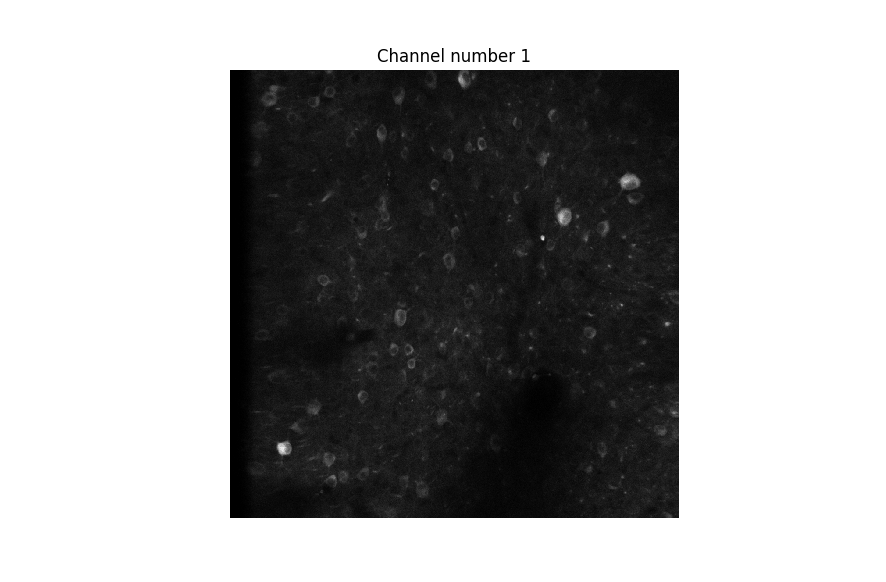

In [20]:
import matplotlib.pyplot as plt
%matplotlib notebook

movie.show_summed()

`show_summed()` and `show_stack()` are two methods to display the data. `show_summed` used the `summed_mem` attribute of `movie`, while `show_stack` uses the `stack` attribute.

`summed_mem` is the "summed stack" of the time lapse. Meaning that the time dimension was summed, leaving the rest of the dimensions untouched. In this case our data is three-dimensional: $x, y$ and $t$. `summed_mem` summed over the $t$ dimension. The `[1]` index is used to access the data at the first spectral channel. Since the data is monochromatic as the mouse was labeled with GCaMP6f only, this is the only relevant spectral channel.

If you wish to access the entire time lapse stack, you may do so with the `stack` attribute.

## Comparison With Analog Acquisition

As noted in the article, PySight's output is superior in terms of $\Delta F/F$ over analog acquisition. A time lapse acquired using ScaImage of the same field of view in the same mouse, just before the digitally acquired data is also supplied for comparison purposes. 

### Analog data setup

Both movies were acquired at 15 Hz, but we acquired a few extra frames during the digital acquisition, so we have to correct it. We'll also display the analog data and subtract the minimal value from the analog image - this is unncessary for PySight-generated volumes since most pixels are black, i.e. have a value of 0.

In [162]:
pysight_data = movie.stack[1][:500]
print(f"PySight's background is {pysight_data.min()}.")

PySight's background is 0.


In [160]:
gdd.download_file_from_google_drive(file_id='1Dp-0PdLtxwh2aJ4yZIOnXXEHzdtRNz3d',
                                    dest_path='./si_analog_data.tif',
                                    unzip=False)

In [154]:
import tifffile
import numpy as np
import matplotlib.patches as patches
import dff_calc.df_f_calculation

The analog background is 32401.


<IPython.core.display.Javascript object>


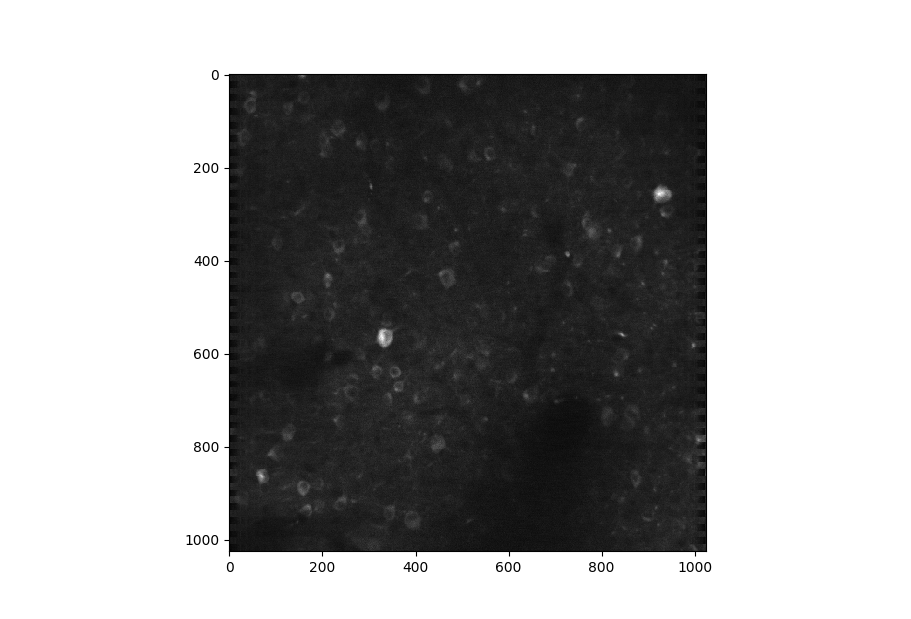

In [163]:
analog_data = tifffile.imread('si_analog_data.tif')
analog_background = analog_data.min()
print(f"The analog background is {analog_background}.")
analog_data = analog_data.astype(np.int32) - analog_data.min()
analog_data = analog_data.astype(np.int16)
summed_analog = analog_data.sum(axis=0)
fig, ax = plt.subplots()
ax.imshow(summed_analog, cmap='gray')

As you're able to see, the field of view is identical to the first stack we've shown.

### Region-of-interest analysis

Let's examine two raw traces from specific regions of interest in the image - a "black" area and a cell.

In [191]:
def create_patch(data: np.ndarray, corner: tuple, size: tuple, color: str):
    """ 
    Create a patch object and pull out the mean data values inside that patch.
    Returns the data object and the patch. 
    """
    patch = patches.Rectangle(corner, size[0], size[1], color=color, fill=False)
    mean_data = data[:, 
                     corner[1]:corner[1]+size[0], 
                     corner[0]:corner[0]+size[1]].mean(axis=(1, 2))
    return mean_data, patch

<IPython.core.display.Javascript object>


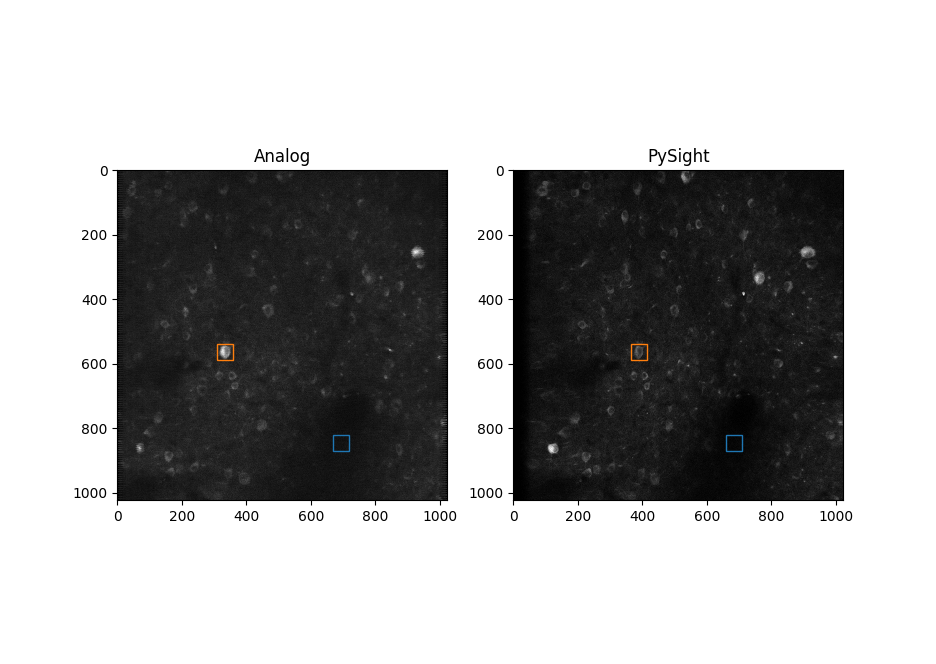

Text(0.5,1,'PySight')

In [193]:
fig_roi, ax_rois = plt.subplots(1, 2)
ax_rois[0].imshow(summed_analog, cmap='gray')
ax_rois[1].imshow(movie.summed_mem[1], cmap='gray')

# Analog
# "Dark" patch
dark_corner_an = 670, 820
width, height = 50, 50
dark_trace_analog, rect_dark_an = create_patch(analog_data, dark_corner_an, 
                                               (width, height), 'C0')

# Cell patch
cell_corner_an = 310, 537
cell_trace_analog, rect_cell_an = create_patch(analog_data, cell_corner_an, 
                                               (width, height), 'C1')

# Digital (coordinates a bit different, and we want this to be a fair comparison)
dark_corner_ps = 660, 820
dark_trace_pysight, rect_dark_ps = create_patch(pysight_data, dark_corner_ps, 
                                                (width, height), 'C0')

cell_corner_ps = 365, 537
cell_trace_pysight, rect_cell_ps = create_patch(pysight_data, cell_corner_ps, 
                                                (width, height), 'C1')

ax_rois[0].add_patch(rect_dark_an)
ax_rois[0].add_patch(rect_cell_an)
ax_rois[1].add_patch(rect_dark_ps)
ax_rois[1].add_patch(rect_cell_ps)
ax_rois[0].set_title('Analog')
ax_rois[1].set_title('PySight')

In [243]:
# Calculate dF/F
dff_arr = np.array([dark_trace_analog, cell_trace_analog, dark_trace_pysight, cell_trace_pysight])
fps = 15.24  # Hz
result = dff_calc.df_f_calculation.DffCalculator(dff_arr, fps=fps).calc()

<IPython.core.display.Javascript object>


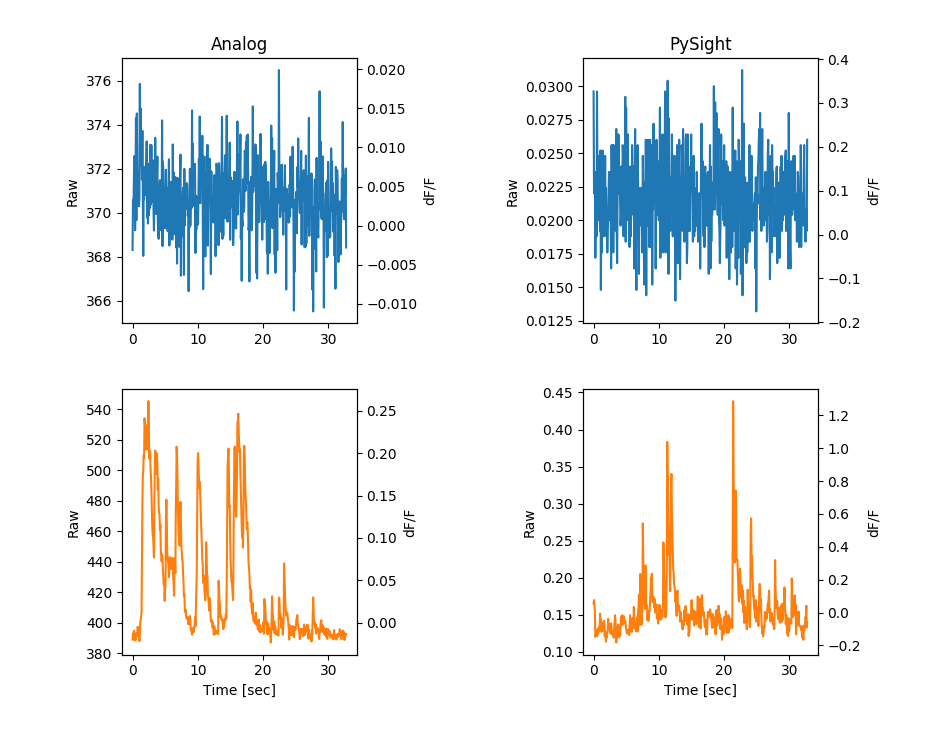

In [244]:
# Display the results
time = np.arange(500) / fps
fig_trace, ax_trace = plt.subplots(2, 2)
ax_trace[0, 0].plot(time, dark_trace_analog, c='C0')
ax_trace[0, 0].set_ylabel('Raw')
dff_ana_dark = ax_trace[0, 0].twinx()
dff_ana_dark.plot(time, result[0, :], alpha=0)
dff_ana_dark.set_ylabel('dF/F')
ax_trace[0, 0].set_title('Analog')

ax_trace[1, 0].plot(time, cell_trace_analog, c='C1')
ax_trace[1, 0].set_ylabel('Raw')
ax_trace[1, 0].set_xlabel('Time [sec]')
dff_ana_cell = ax_trace[1, 0].twinx()
dff_ana_cell.plot(time, result[1, :], alpha=0, c='C0')
dff_ana_cell.set_ylabel('dF/F')

ax_trace[0, 1].plot(time, dark_trace_pysight, c='C0')
ax_trace[0, 1].set_ylabel('Raw')
ax_trace[0, 1].set_title('PySight')
dff_ps_dark = ax_trace[0, 1].twinx()
dff_ps_dark.plot(time, result[2, :], alpha=0)
dff_ps_dark.set_ylabel('dF/F')

ax_trace[1, 1].plot(time, cell_trace_pysight, c='C1')
ax_trace[1, 1].set_ylabel('Raw')
ax_trace[1, 1].set_xlabel('Time [sec]')
dff_ps_cell = ax_trace[1, 1].twinx()
dff_ps_cell.plot(time, result[3, :], alpha=0)
dff_ps_cell.set_ylabel('dF/F')

fig_trace.tight_layout()

The results are clear - dark areas in the original field of view are much darker in PySight than they are during analog acquisition. Moreover, spike-like events are more prominent in the digitial acquistion modality. Using `dff-calc`, a simple package that calculates $\Delta F / F$ from raw traces, we see an order-of-magnitude difference in the $\Delta F/F$ values between the two acquisition methods.

## Addendum: Verifying the Chosen Analog Gain

While the gain for the PySight acquisition was always set to 850 mV, the gain during the analog acquisition varied, and was usually about 650 mV. Before each experiment we would find the gain that produces the highest available SNR during imaging, and stick with it. In one of the experiments we also imaged with PySight-like gains of 850 mV in order to verify that our choice of gain was indeed the right one. Below you'll find examples justifying this choice.

<IPython.core.display.Javascript object>


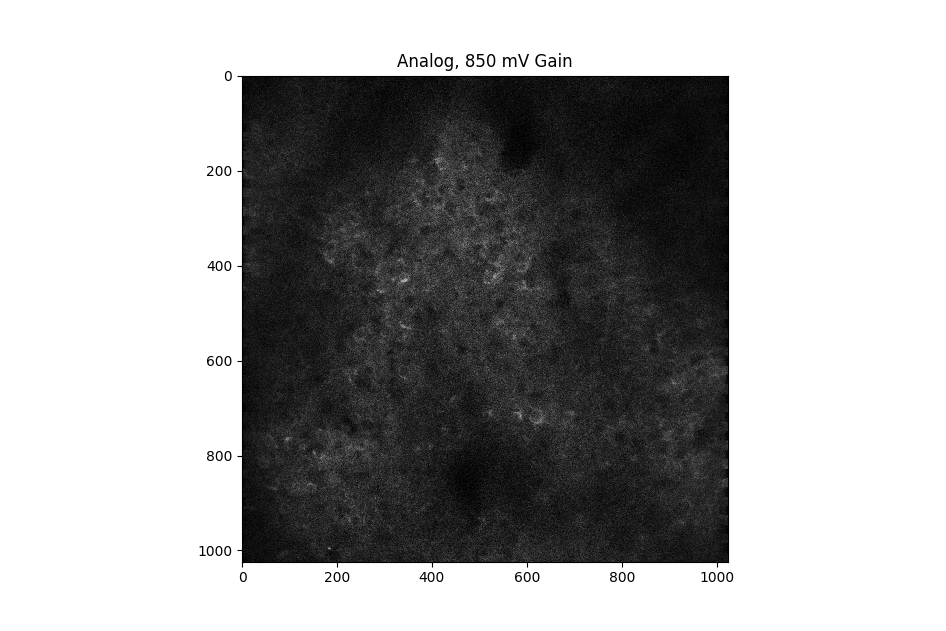

In [240]:
an_850 = tifffile.imread(r'./FOV2_850gain_00001.tif')[:500]
fig_850, ax_850 = plt.subplots()
an_850_mean = an_850.mean(axis=0)
ax_850.imshow(an_850_mean, cmap='gray')
ax_850.set_title('Analog, 850 mV Gain')

<IPython.core.display.Javascript object>


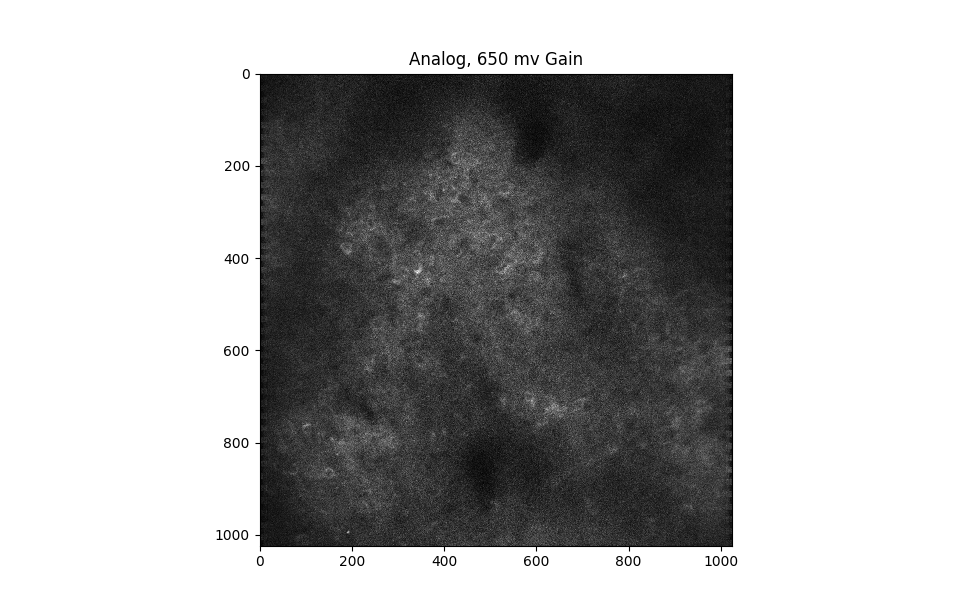

In [212]:
an_650 = tifffile.imread(r'./FOV2_650gain_00002.tif')[:500]
fig_650, ax_650 = plt.subplots()
an_650_mean = an_650.mean(axis=0)
ax_650.imshow(an_650_mean, cmap='gray')
ax_650.set_title('Analog, 650 mv Gain')

<IPython.core.display.Javascript object>


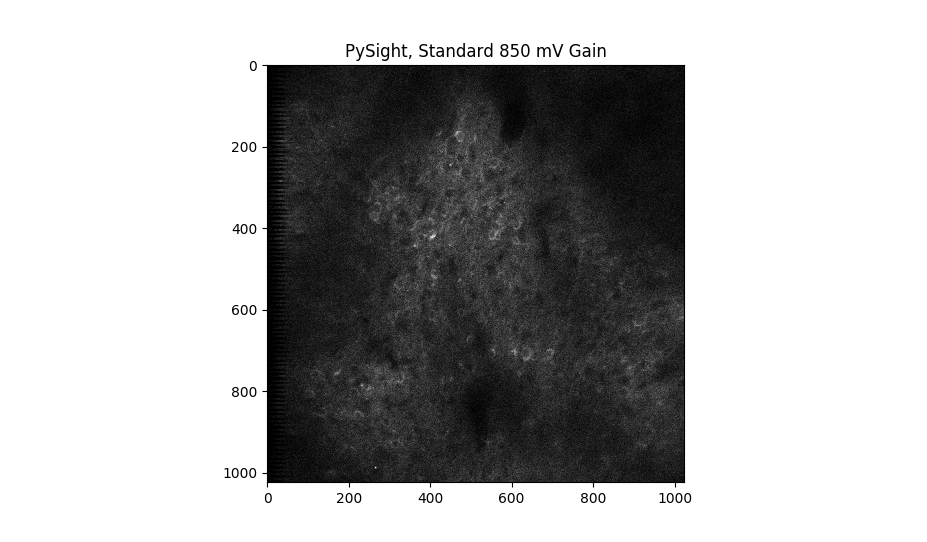

Text(0.5,1,'PySight, Standard 850 mV Gain')

In [271]:
ps = tifffile.imread(
    r'./ps_fov2_comp.tif')[:500]
fig_ps, ax_ps = plt.subplots()
ps_mean = ps.mean(axis=0)
ax_ps.imshow(ps_mean, cmap='gray')
ax_ps.set_title('PySight, Standard 850 mV Gain')

In [369]:
cell1 = (679, 700)
cell1_p = (675, 695)
cell2 = (600, 695)
cell2_p = (618, 688)
cell3 = (900, 935)
cell3_p = (896, 920)
cell4 = (403, 168)
cell4_p = (457, 161)
size = (40, 40)

cell1_650, rect1_650 = create_patch(an_650, cell1, size, 'C0')
cell1_850, rect1_850 = create_patch(an_850, cell1, size, 'C0')
cell1_ps, rect1_ps = create_patch(ps, cell1_p, size, 'C0')
cell2_650, rect2_650 = create_patch(an_650, cell2, size, 'C1')
cell2_850, rect2_850 = create_patch(an_850, cell2, size, 'C1')
cell2_ps, rect2_ps = create_patch(ps, cell2_p, size, 'C1')
cell3_650, rect3_650 = create_patch(an_650, cell3, size, 'C2')
cell3_850, rect3_850 = create_patch(an_850, cell3, size, 'C2')
cell3_ps, rect3_ps = create_patch(ps, cell3_p, size, 'C2')
cell4_650, rect4_650 = create_patch(an_650, cell4, size, 'C3')
cell4_850, rect4_850 = create_patch(an_850, cell4, size, 'C3')
cell4_ps, rect4_ps = create_patch(ps, cell4_p, size, 'C3')

<IPython.core.display.Javascript object>


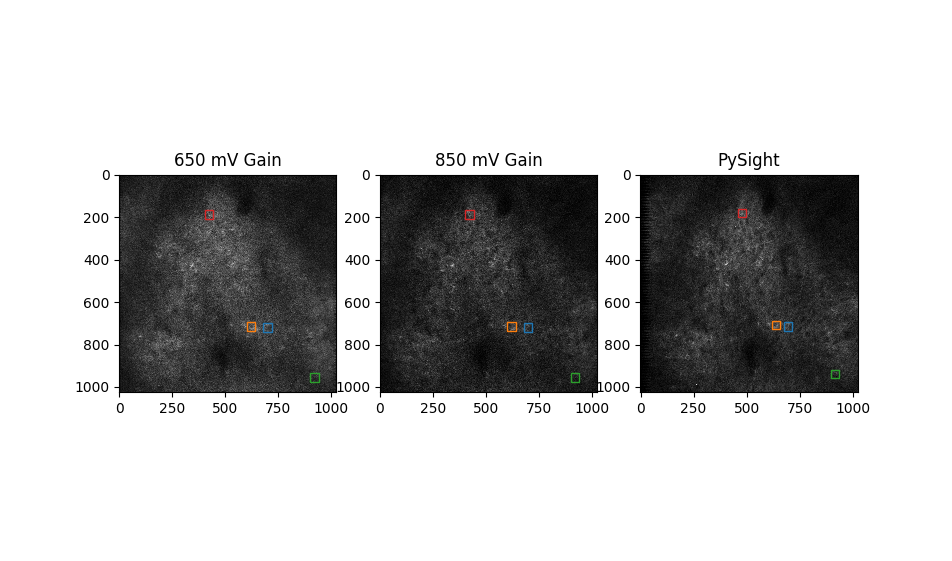

Text(0.5,1,'PySight')

In [370]:
fig_an_comp, ax_an_comp = plt.subplots(1, 3)
ax_an_comp[0].imshow(an_650_mean, cmap='gray')
ax_an_comp[1].imshow(an_850_mean, cmap='gray')
ax_an_comp[2].imshow(ps_mean, cmap='gray')
ax_an_comp[0].add_patch(rect1_650)
ax_an_comp[1].add_patch(rect1_850)
ax_an_comp[2].add_patch(rect1_ps)
ax_an_comp[0].add_patch(rect2_650)
ax_an_comp[1].add_patch(rect2_850)
ax_an_comp[2].add_patch(rect2_ps)
ax_an_comp[0].add_patch(rect3_650)
ax_an_comp[1].add_patch(rect3_850)
ax_an_comp[2].add_patch(rect3_ps)
ax_an_comp[0].add_patch(rect4_650)
ax_an_comp[1].add_patch(rect4_850)
ax_an_comp[2].add_patch(rect4_ps)

ax_an_comp[0].set_title('650 mV Gain')
ax_an_comp[1].set_title('850 mV Gain')
ax_an_comp[2].set_title('PySight')

In [371]:
# Calculate dF/F
dff_arr_comp = np.array([cell1_650, cell1_850, cell1_ps,
                         cell2_650, cell2_850, cell2_ps,
                         cell3_650, cell3_850, cell3_ps,
                         cell4_650, cell4_850, cell4_ps])
fps = 15.24  # Hz
result_comp = dff_calc.df_f_calculation.DffCalculator(dff_arr_comp, fps=fps).calc()

In [364]:
def show_trace(ax, x, y, dff, c, row_idx, col_idx):
    ax[row_idx, col_idx].plot(x, y, c=c)
    ax[row_idx, col_idx].set_ylabel('Raw')
    ax2 = ax[row_idx, col_idx].twinx()
    ax2.plot(x, dff[row_idx*3 + col_idx, :], alpha=0)
    ax2.set_ylabel('dF/F')

<IPython.core.display.Javascript object>


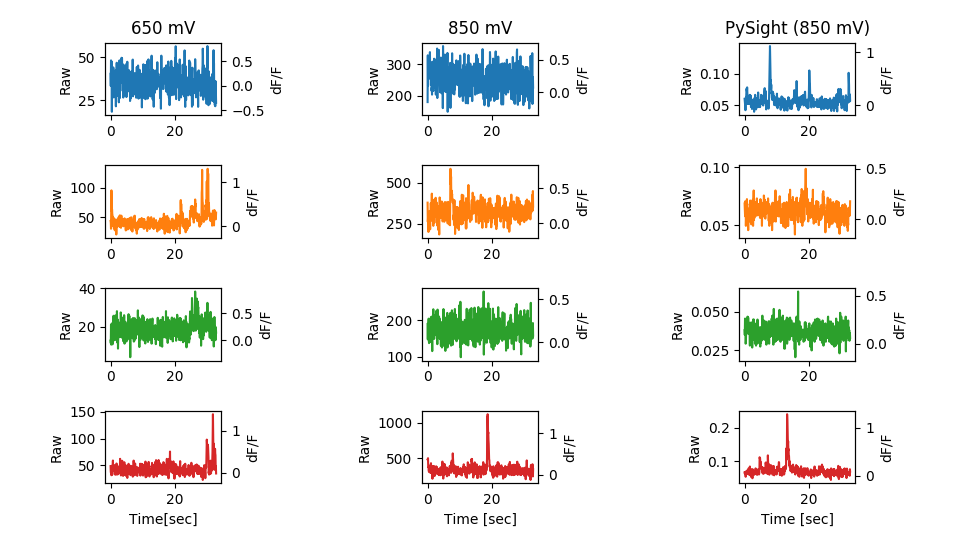

In [372]:
# Display the results
time = np.arange(500) / fps
fig_an, ax_an = plt.subplots(4, 3)

show_trace(ax_an, time, cell1_650, result_comp, 'C0', 0, 0)
show_trace(ax_an, time, cell1_850, result_comp, 'C0', 0, 1)
show_trace(ax_an, time, cell1_ps, result_comp, 'C0', 0, 2)

show_trace(ax_an, time, cell2_650, result_comp, 'C1', 1, 0)
show_trace(ax_an, time, cell2_850, result_comp, 'C1', 1, 1)
show_trace(ax_an, time, cell2_ps, result_comp, 'C1', 1, 2)

show_trace(ax_an, time, cell3_650, result_comp, 'C2', 2, 0)
show_trace(ax_an, time, cell3_850, result_comp, 'C2', 2, 1)
show_trace(ax_an, time, cell3_ps, result_comp, 'C2', 2, 2)

show_trace(ax_an, time, cell4_650, result_comp, 'C3', 3, 0)
show_trace(ax_an, time, cell4_850, result_comp, 'C3', 3, 1)
show_trace(ax_an, time, cell4_ps, result_comp, 'C3', 3, 2)

ax_an[0, 0].set_title('650 mV')
ax_an[0, 1].set_title('850 mV')
ax_an[0, 2].set_title('PySight (850 mV)')

ax_an[3, 0].set_xlabel('Time[sec]')
ax_an[3, 1].set_xlabel('Time [sec]')
ax_an[3, 2].set_xlabel('Time [sec]')

fig_an.tight_layout()